In [17]:
import os
import sys
from scipy.integrate import simps
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import json


project_dir = "D:/MDSI_project/"
func_dir = "ANSYS_Building_model/PyAPDL_example/FUNC"
doe_dir = "ANSYS_Building_model/PyAPDL_example/DOE_data"
sys.path.append(os.path.join(project_dir, func_dir))
sys.path.append(os.path.join(project_dir, doe_dir))

func_dir_ = os.path.join(project_dir, func_dir)
doe_dir_ = os.path.join(project_dir, doe_dir)

from Simulation_PyAPDL import simulation_PyAPDL
import func_FEMU as FEMU



1st natural freqeuncy: 12.1344, 2nd natural freqeuncy: 18.8672


### Activate the pymAPDL server

In [2]:
simu_tk = simulation_PyAPDL(nproc=4,nerr=10000)
simu_tk.launch_engine()
simu_tk.mapdl.clear()

Launch Pymapdl
     Launch Pymapdl successfully, duration 3.0256 seconds.


### Generate DOE using LHS
- fix parameter: all of the nu
- vary parameter: t, e, rho, vs, dr, height
- Assumption: x_slab = t_stair
- Number of parameter reduced to: 19

In [4]:
from pyDOE import lhs
import numpy as np
import json

# Generate LHS data
num_samples = 1000  # Number of samples
num_parameters = 19  # Number of parameters

# Create LHS data in [0, 1] range
X_samples = lhs(num_parameters, samples=num_samples)

# Convert to a Python list for JSON compatibility
X_samples_list = X_samples.tolist()


# Save to a JSON file
#with open('lhs_data.json', 'w') as json_file:
#    json.dump(X_samples_list, json_file, indent=4)  # indent for better readability
#print("LHS data saved to 'lhs_data.json'")



## Geernrateing the simulation result
- Input the parameter sets from lhs_data.json
- Using bool_SSI to design whether require SSI features, if false, then SSI will be turned off and the parameter: soil_para will have no effects
- Varying the parameters $X_{i}$ with the range in $R_{vary} \cdot X_{i} \cdot [ 0, 1]$, where $X_{i}$ is the current paramter and $R_{vary}$ is vary_ratio.
- The parameter sets of the building strucutre are [slab , corridor, ground, edge_wall, inner_wall, stair]
- Assumning the mean of parameter sets for thickness are [0.468, 0.8, 0.05, 0.2, 0.2, 0.468] (m)
- Assumning the mean of parameter sets for Young's modulus are [20e9, 20e9, 20e9, 20e9, 20e9, 20e9] (pa)
- Assumning the mean of parameter sets for possion's ratio are [0.27 0.27 0.27, 0.27, 0.27] (-)
- Assumning the mean of parameter sets for density are [2300, 2300, 2300, 2300, 2300] ($\frac{kg}{m^{3}}$)
- Assumning the mean of parameter sets for soil are [350, 1400, 0.33] w.r.t Shear wave velocity, density and possion's ratio.
- Assumning the mean of height of each floor is 3.37 (m)
- Assumning the mean of damping ratio is 0.045 (-)

### Note
- In my case, each simulation took approximate 1.5 mins for harmonic analysis using MSUP method (Solu_type=6).
- The result should be stored in ```os.path.join(project_dir, "/PCE_surrogate/InputData/Realization_frf_noSSI/")``` as default with the dict data structure.

In [ ]:
import os
from IPython.display import clear_output

DOE_info = {}
vary_ratio = 0.5
# Load the JSON file
with open(os.path.join(doe_dir_,'lhs_data.json'), 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert back to a NumPy array if needed
X = np.array(loaded_data)
# Transform X from [0,1] to [-1,1]
X_transformed = 2 * X - 1


directory = os.path.join(project_dir, "PCE_surrogate/InputData/Realization_frf/")
for i_doe in range(0,1000):
    filename = f"DOE_result_{i_doe}.json"
    full_path = os.path.join(directory, filename)
    X_doe = X[i_doe,:]
    X_doe_transformed = X_transformed[i_doe,:]

    simu_tk.mapdl.clear()

    # Parameter list    = [slab ,corridor, ground, edge_wall, inner_wall, stair ]
    t_para   = np.array([ 0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0],
                          0.8  + vary_ratio*(0.8  )*X_transformed[i_doe,1],
                          0.05 + vary_ratio*(0.05 )*X_transformed[i_doe,2],
                          0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,3],
                          0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,4],
                          0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0]])
    
    e_para   = np.array([ 20e9 + vary_ratio*20e9*X_transformed[i_doe,5],
                          20e9 + vary_ratio*20e9*X_transformed[i_doe,6],
                          20e9 + vary_ratio*20e9*X_transformed[i_doe,7],
                          20e9 + vary_ratio*20e9*X_transformed[i_doe,8],
                          20e9 + vary_ratio*20e9*X_transformed[i_doe,9],
                          20e9 + vary_ratio*20e9*X_transformed[i_doe,5]])
    
    nu_para  = np.array([ 0.27,
                          0.27,
                          0.27,
                          0.27,
                          0.27,
                          0.27])
    
    rho_para = np.array([ 2300 + vary_ratio*2300*X_transformed[i_doe,10],
                          2300 + vary_ratio*2300*X_transformed[i_doe,11],
                          2300 + vary_ratio*2300*X_transformed[i_doe,12],
                          2300 + vary_ratio*2300*X_transformed[i_doe,13],
                          2300 + vary_ratio*2300*X_transformed[i_doe,14],
                          2300 + vary_ratio*2300*X_transformed[i_doe,10]])
    
    # Parameter list    = [ vs,   rho,   nu ]
    soil_para = np.array([ 350  + vary_ratio*(350 )*X_transformed[i_doe,15],
                           1400 + vary_ratio*(1400)*X_transformed[i_doe,16],
                           0.33 ])
    
    height_b            = 3.37 + vary_ratio*3.37*X_transformed[i_doe,17]
    damp_ratio_b        = 0.045+ 0.01*X_transformed[i_doe,18]

    # With SSI feature
    simu_tk.setting_parameter(bool_SSI= True,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()

    # Excitation point: Hammer 2.0 Pos1 (shaker)
    tol = 0.3
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',9.3-tol,9.3+tol)
    nsel_id_1 = simu_tk.mapdl.nsel('R','LOC','Y',5.9-tol,5.9+tol)
    simu_tk.mapdl.nsel('ALL')


    # Excitation point: Hammer 2.0 Pos2 (sensor)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',7.19-tol,7.19+tol)
    nsel_id_2 = simu_tk.mapdl.nsel('R','LOC','Y',8.14-tol,8.14+tol)
    print(nsel_id_2)
    simu_tk.mapdl.nsel('ALL')

    # Excitation point: Hammer 2.1 Pos1 (close to edge)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',12.776-tol,12.776+tol)
    nsel_id_3 = simu_tk.mapdl.nsel('R','LOC','Y',2.748-tol,2.748+tol)
    print(nsel_id_3)
    simu_tk.mapdl.nsel('ALL')

    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1.0, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_1[1])
    

    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)

 
    ## Get FRF at target point
    meas_FRFs = simu_tk.get_FRFs_meas_EXAMPLE()
  
    
    DOE_info = {
        'id':i_doe,
        'X':X_doe.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs
        }
    with open(full_path, "w") as file:
        json.dump(DOE_info, file, indent=4)  # `indent=4` for pretty printing
    simu_tk.mapdl.clear()
    clear_output(wait=True)
    

### Analysis after generate the resuls
- Once the DOE results are generated and stored in designated path, we can import them from the path and do further analysis.
- DON'T NEED TO RUN THE 1000 SIMULATION EVERY TIME, it will take over 10 hrs.
- There are three case, since we did three hammer testings based on different excitation location.
- The naminr rule is quite confusing since the data are collected from several sides, here is the simple instructions:
  - From the simulation: There are three excitaion event, naming: ex22, ex220, ex221, their excitation locations are marked in the report.
  - From the experiment, the data is stored in ```.mat``` file, which is stored in ```./DATA_GM_RawData/DATA_ACC_Measure12032024/DATA_Hammer/Time_domain_update```
    - The file naming with OG_2_2_0... corresponding to ex220, where are the first to 6th files from the top in the folder, therefore we used the var ```i_file``` = 1...6 to call them.
    - The file naming with OG_2_2_1... corresponding to ex221, where are the 7th to 9th files from the top in the folder, therefore we used the var ```i_file``` = 7...9 to call them.
    - The file naming with OG_2_2... corresponding to ex22, where are the 10th to 13th files from the top in the folder, therefore we used the var ```i_file``` = 10...13 to call them.
- In each experiment ```.mat``` file, there are 19 channels, where the 19th channel is the excitation signal and the CH 9,10,11,12 are the sensors at 1OG and the CH 3,13,14,15 are the sensors at 2OG.

### For case ex220

In [37]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
DOE_info = {}
i_doe_wrong = []
i_doe_valid = []

## Obtain the exp data
# Case 1
i_file = 1
directory = os.path.join(project_dir, "MATLAB/Surrogate_main/FRF/")
filename = f"mode_shape_test_{i_file}.mat"
full_path = os.path.join(directory, filename)

mode_shape_exp = sio.loadmat(full_path)
mode_shape_vector_exp = mode_shape_exp['phi']
mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
mode_1_exp = mode_shape_vector_exp[0::2,3]
mode_2_exp = mode_shape_vector_exp[1::2,3]

mean_fn_1_exp_ex221 = mean_fn_1_exp
mean_fn_2_exp_ex221 = mean_fn_2_exp
print(f"1st natural freqeuncy: {mean_fn_1_exp}, 2nd natural freqeuncy: {mean_fn_2_exp}")

# Load the JSON file
directory = os.path.join(project_dir, "PCE_surrogate/InputData/Realization_frf_ex220/")

MAC_values_1 = np.zeros(1000)
MAC_values_2 = np.zeros(1000)
Fn_values_1 = np.zeros(1000)
Fn_values_2 = np.zeros(1000)
MMI_1 = np.zeros(1000)
MMI_2 = np.zeros(1000)


# Load the JSON file
with open(os.path.join(doe_dir_,'lhs_data.json'), 'r') as json_file:
    loaded_data = json.load(json_file)
# Convert back to a NumPy array if needed
X = np.array(loaded_data)

for i_doe in range(0,1000):

    filename = f"DOE_result_{i_doe}.json"
    full_path = os.path.join(directory, filename)

    ch_list = [1,2,3,7,8,9,10,11,12,13,14,15]
    with open(full_path, 'r') as json_file:
        loaded_data = json.load(json_file)
        #
    for i_ch in ch_list:
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
    #
    meas_FRFs = loaded_data['meas_frf']
    #
    natrual_freq = []
    for i_mode in range(1,loaded_data['modal_info']['total_mode_num']+1):
        natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
    #
    mode_freq_vector, mode_shape_vector = FEMU.extract_mode_shape_vector(natrual_freq,meas_FRFs  )
    #print(mode_freq_vector, mode_shape_vector)
    #
    #
    #i_ch_disp = [9,10,11,12,3,13,14,15]
    i_ch_disp = [9,15]
    mode_freq_1_list = np.zeros(len(i_ch_disp))
    mode_freq_2_list = np.zeros(len(i_ch_disp))
    mac_1_list = np.zeros(len(i_ch_disp))
    mac_2_list = np.zeros(len(i_ch_disp))
    #
    for i_ch in range(len(i_ch_disp)):
        [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = FEMU.find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['imag']),0.05,plot_=False)
    
        mac_1_list[i_ch] = FEMU.get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
        mac_2_list[i_ch] = FEMU.get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
    #
    #print(mode_freq_1_list)
    #print(np.std(find_max_cluster(mode_freq_1_list)))
    #print(f_n_2_mean)
    f_n_1_mean = FEMU.mean_value_filted((mode_freq_1_list),1)
    f_n_2_mean = FEMU.mean_value_filted((mode_freq_2_list),1)

    #print(find_max_cluster(mode_freq_2_list))
    mac_1_mean = FEMU.mean_value_filted(mac_1_list,1)
    mac_2_mean = FEMU.mean_value_filted(mac_2_list,1)

    #print(mac_1_mean, mac_2_mean)
    MAC_values_1[i_doe] = mac_1_mean
    MAC_values_2[i_doe] = mac_2_mean
    Fn_values_1[i_doe] = f_n_1_mean
    Fn_values_2[i_doe] = f_n_2_mean
    MMI_1[i_doe] = FEMU.get_MMI(f_n_1_mean,mean_fn_1_exp,mac_1_mean,0.7)
    MMI_2[i_doe] = FEMU.get_MMI(f_n_2_mean,mean_fn_2_exp,mac_2_mean,0.7)
    if mac_1_mean <= 0.6 or mac_2_mean <= 0.5:
        i_doe_wrong.append(i_doe)
    else:
        i_doe_valid.append(i_doe)
    
    #for i_plot in i_ch_disp:
    #    plt.plot(loaded_data['meas_frf'][f'disp_ch{i_plot}']['freq'], loaded_data['meas_frf'][f'disp_ch{i_plot}']['imag'],linestyle=":")
    #plt.axvline(x=f_n_1_mean, color='red', linestyle='--', label=f'fn1:{f_n_1_mean}')
    #plt.axvline(x=f_n_2_mean, color='red', linestyle='--', label=f'fn2:{f_n_2_mean}')
    #plt.title(f'i_doe: {i_doe}')
    #plt.legend()
    #plt.show()

valid_X0_ex220 = X[i_doe_valid]
valid_Y1_ex220 = Fn_values_1[i_doe_valid]
valid_Y2_ex220 = Fn_values_2[i_doe_valid]

1st natural freqeuncy: 12.2112, 2nd natural freqeuncy: 18.8672


### For case ex22

In [38]:
import os
import json
import numpy as np
DOE_info = {}
i_doe_wrong = []
i_doe_valid = []

# Load the JSON file
i_doe = 13
directory = os.path.join(project_dir, "PCE_surrogate/InputData/Realization_frf/")

MAC_values_1 = np.zeros(1000)
MAC_values_2 = np.zeros(1000)
Fn_values_1 = np.zeros(1000)
Fn_values_2 = np.zeros(1000)
MMI_1 = np.zeros(1000)
MMI_2 = np.zeros(1000)


# Load the JSON file
with open(os.path.join(doe_dir_,'lhs_data.json'), 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert back to a NumPy array if needed
X = np.array(loaded_data)

for i_doe in range(0,1000):

    filename = f"DOE_result_{i_doe}.json"
    full_path = os.path.join(directory, filename)

    ch_list = [1,2,3,7,8,9,10,11,12,13,14,15]
    with open(full_path, 'r') as json_file:
        loaded_data = json.load(json_file)
        #
    for i_ch in ch_list:
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
    #
    meas_FRFs = loaded_data['meas_frf']
    #
    natrual_freq = []
    for i_mode in range(1,18):
        natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
    #
    mode_freq_vector, mode_shape_vector = FEMU.extract_mode_shape_vector(natrual_freq,meas_FRFs  )
    #print(mode_freq_vector, mode_shape_vector)
    #
    mode_freq_1_list = np.zeros(8)
    mode_freq_2_list = np.zeros(8)
    mac_1_list = np.zeros(8)
    mac_2_list = np.zeros(8)
    #
    i_ch_disp = [9,10,11,12,3,13,14,15]
    for i_ch in range(8):
    #
        [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = FEMU.find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['imag']),0.05)
        mac_1_list[i_ch] = FEMU.get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
        mac_2_list[i_ch] = FEMU.get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
    #
    f_n_1_mean = FEMU.mean_value_filted(mode_freq_1_list,1)
    f_n_2_mean = FEMU.mean_value_filted(mode_freq_2_list,1)
    mac_1_mean = FEMU.mean_value_filted(mac_1_list,1)
    mac_2_mean = FEMU.mean_value_filted(mac_2_list,1)

    #print(mac_1_mean, mac_2_mean)
    MAC_values_1[i_doe] = mac_1_mean
    MAC_values_2[i_doe] = mac_2_mean
    Fn_values_1[i_doe] = f_n_1_mean
    Fn_values_2[i_doe] = f_n_2_mean
    MMI_1[i_doe] = FEMU.get_MMI(f_n_1_mean,mean_fn_1_exp,mac_1_mean,0.7)
    MMI_2[i_doe] = FEMU.get_MMI(f_n_2_mean,mean_fn_2_exp,mac_2_mean,0.7)
    if mac_1_mean <= 0.4 or mac_2_mean <= 0.4:
        i_doe_wrong.append(i_doe)
    else:
        i_doe_valid.append(i_doe)
    
    #for i_plot in i_ch_disp:
    #    plt.plot(loaded_data['meas_frf'][f'disp_ch{i_plot}']['freq'], loaded_data['meas_frf'][f'disp_ch{i_plot}']['imag'],linestyle=":")
    #plt.axvline(x=f_n_1_mean, color='red', linestyle='--', label=f'fn1:{f_n_1_mean}')
    #plt.axvline(x=f_n_2_mean, color='red', linestyle='--', label=f'fn2:{f_n_2_mean}')
    #plt.title(f'i_doe: {i_doe}')
    #plt.legend()
    #plt.show()

valid_X = X[i_doe_valid]
valid_Y0 = MMI_1[i_doe_valid]
valid_Y1 = MMI_2[i_doe_valid]
valid_Y2 = Fn_values_1[i_doe_valid]
valid_Y3 = Fn_values_2[i_doe_valid]
valid_Y4 = MAC_values_1[i_doe_valid]
valid_Y5 = MAC_values_2[i_doe_valid]





### Using Random Forest Classifier extract the featrue importance

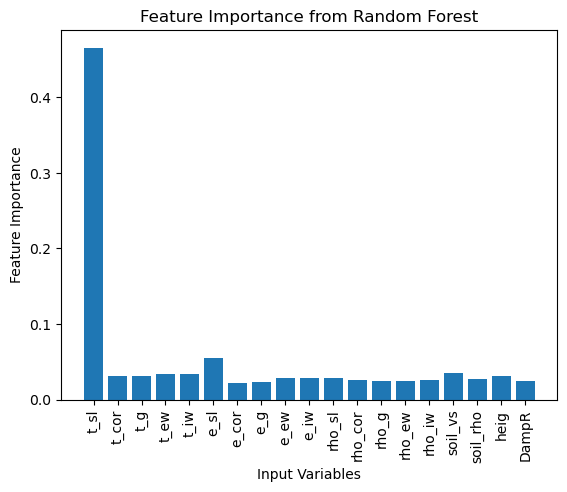

              precision    recall  f1-score   support

         0.0       0.82      0.81      0.82        93
         1.0       0.91      0.92      0.92       207

    accuracy                           0.89       300
   macro avg       0.87      0.86      0.87       300
weighted avg       0.89      0.89      0.89       300



In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load the JSON file
with open(os.path.join(doe_dir_,'lhs_data.json'), 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert back to a NumPy array if needed
X = np.array(loaded_data)
y = np.ones(1000)
y[i_doe_wrong] = 0

input_name = ['t_sl' ,'t_cor', 't_g', 't_ew', 't_iw',
              'e_sl' ,'e_cor', 'e_g', 'e_ew', 'e_iw',
              'rho_sl' ,'rho_cor', 'rho_g', 'rho_ew', 'rho_iw',
              'soil_vs' ,'soil_rho', 'heig', 'DampR']

# Create a DataFrame for easier handling
data = pd.DataFrame(X, columns=input_name)
data['fn_1'] = Fn_values_1
data['fn_2'] = Fn_values_2
data['MAC_1'] = MAC_values_1
data['MAC_2'] = MAC_values_2
data['non'] = MAC_values_2


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Get feature importance
feature_importance = clf.feature_importances_

# Print or visualize feature importance

plt.bar(range(len(feature_importance)), feature_importance,tick_label = input_name)
plt.xlabel("Input Variables")
plt.ylabel("Feature Importance")
plt.title("Feature Importance from Random Forest")
plt.xticks(rotation=90)
plt.show()

# Evaluate the classifier
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))







### Find the correlation using pearson and spearman method

(647, 24)


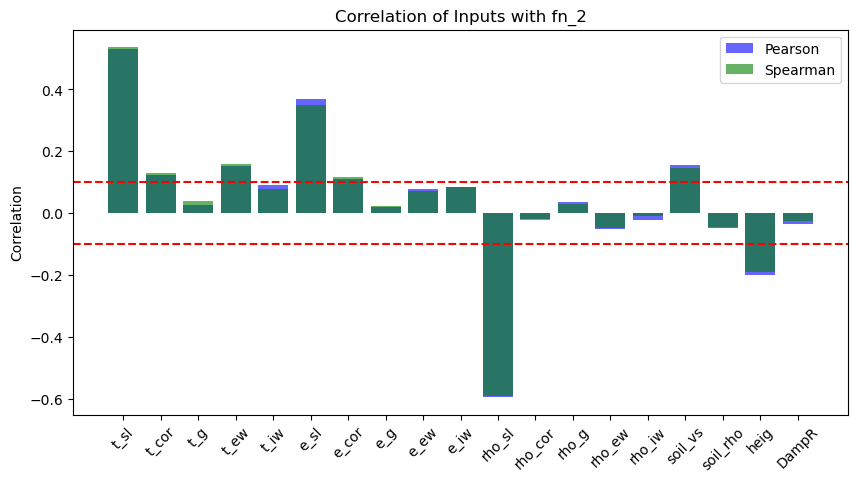

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


data_type = 'fn_2'


# Load the JSON file
with open(os.path.join(doe_dir_,'lhs_data.json'), 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert back to a NumPy array if needed
X = np.array(loaded_data)
input_name = ['t_sl' ,'t_cor', 't_g', 't_ew', 't_iw',
              'e_sl' ,'e_cor', 'e_g', 'e_ew', 'e_iw',
              'rho_sl' ,'rho_cor', 'rho_g', 'rho_ew', 'rho_iw',
              'soil_vs' ,'soil_rho', 'heig', 'DampR']

# Create a DataFrame for easier handling
data = pd.DataFrame(X, columns=input_name)
data['fn_1'] = Fn_values_1
data['fn_2'] = Fn_values_2
data['MAC_1'] = MAC_values_1
data['MAC_2'] = MAC_values_2
data['non'] = MAC_values_2

data = data[data['MAC_1'] >= 0.4]
data = data[data['MAC_2'] >= 0.4]

print(np.shape(data))

# Compute Pearson correlation
pearson_corr = data.corr(method='pearson')[data_type][:-1]  # Exclude 'MAC' with itself

# Compute Spearman correlation
spearman_corr = data.corr(method='spearman')[data_type][:-1]  # Exclude 'MAC' with itself

sorted_pearson = pearson_corr.abs().sort_values(ascending=False)
sorted_spearman = spearman_corr.abs().sort_values(ascending=False)

#print("Top Inputs by Pearson Correlation:")
#print(sorted_pearson.head())

#print("Top Inputs by Spearman Correlation:")
#print(sorted_spearman.head())


# Plot correlations
plt.figure(figsize=(10, 5))
plt.bar(range(len(pearson_corr))[:19], pearson_corr[:19], label='Pearson', alpha=0.6, color='blue')
plt.bar(range(len(spearman_corr))[:19], spearman_corr[:19], label='Spearman', alpha=0.6, color='green')
plt.axhline(y=0.1, color='red', linestyle='--')
plt.axhline(y=-0.1, color='red', linestyle='--')

plt.xticks(range(len(pearson_corr))[:19], pearson_corr.index[:19], rotation=45)
plt.ylabel('Correlation')
plt.title(f'Correlation of Inputs with {data_type}')
plt.legend()
plt.show()


### Visualization of correlation
- Only focus on the data that MAC 1 and MAC 2 larger than 0.4

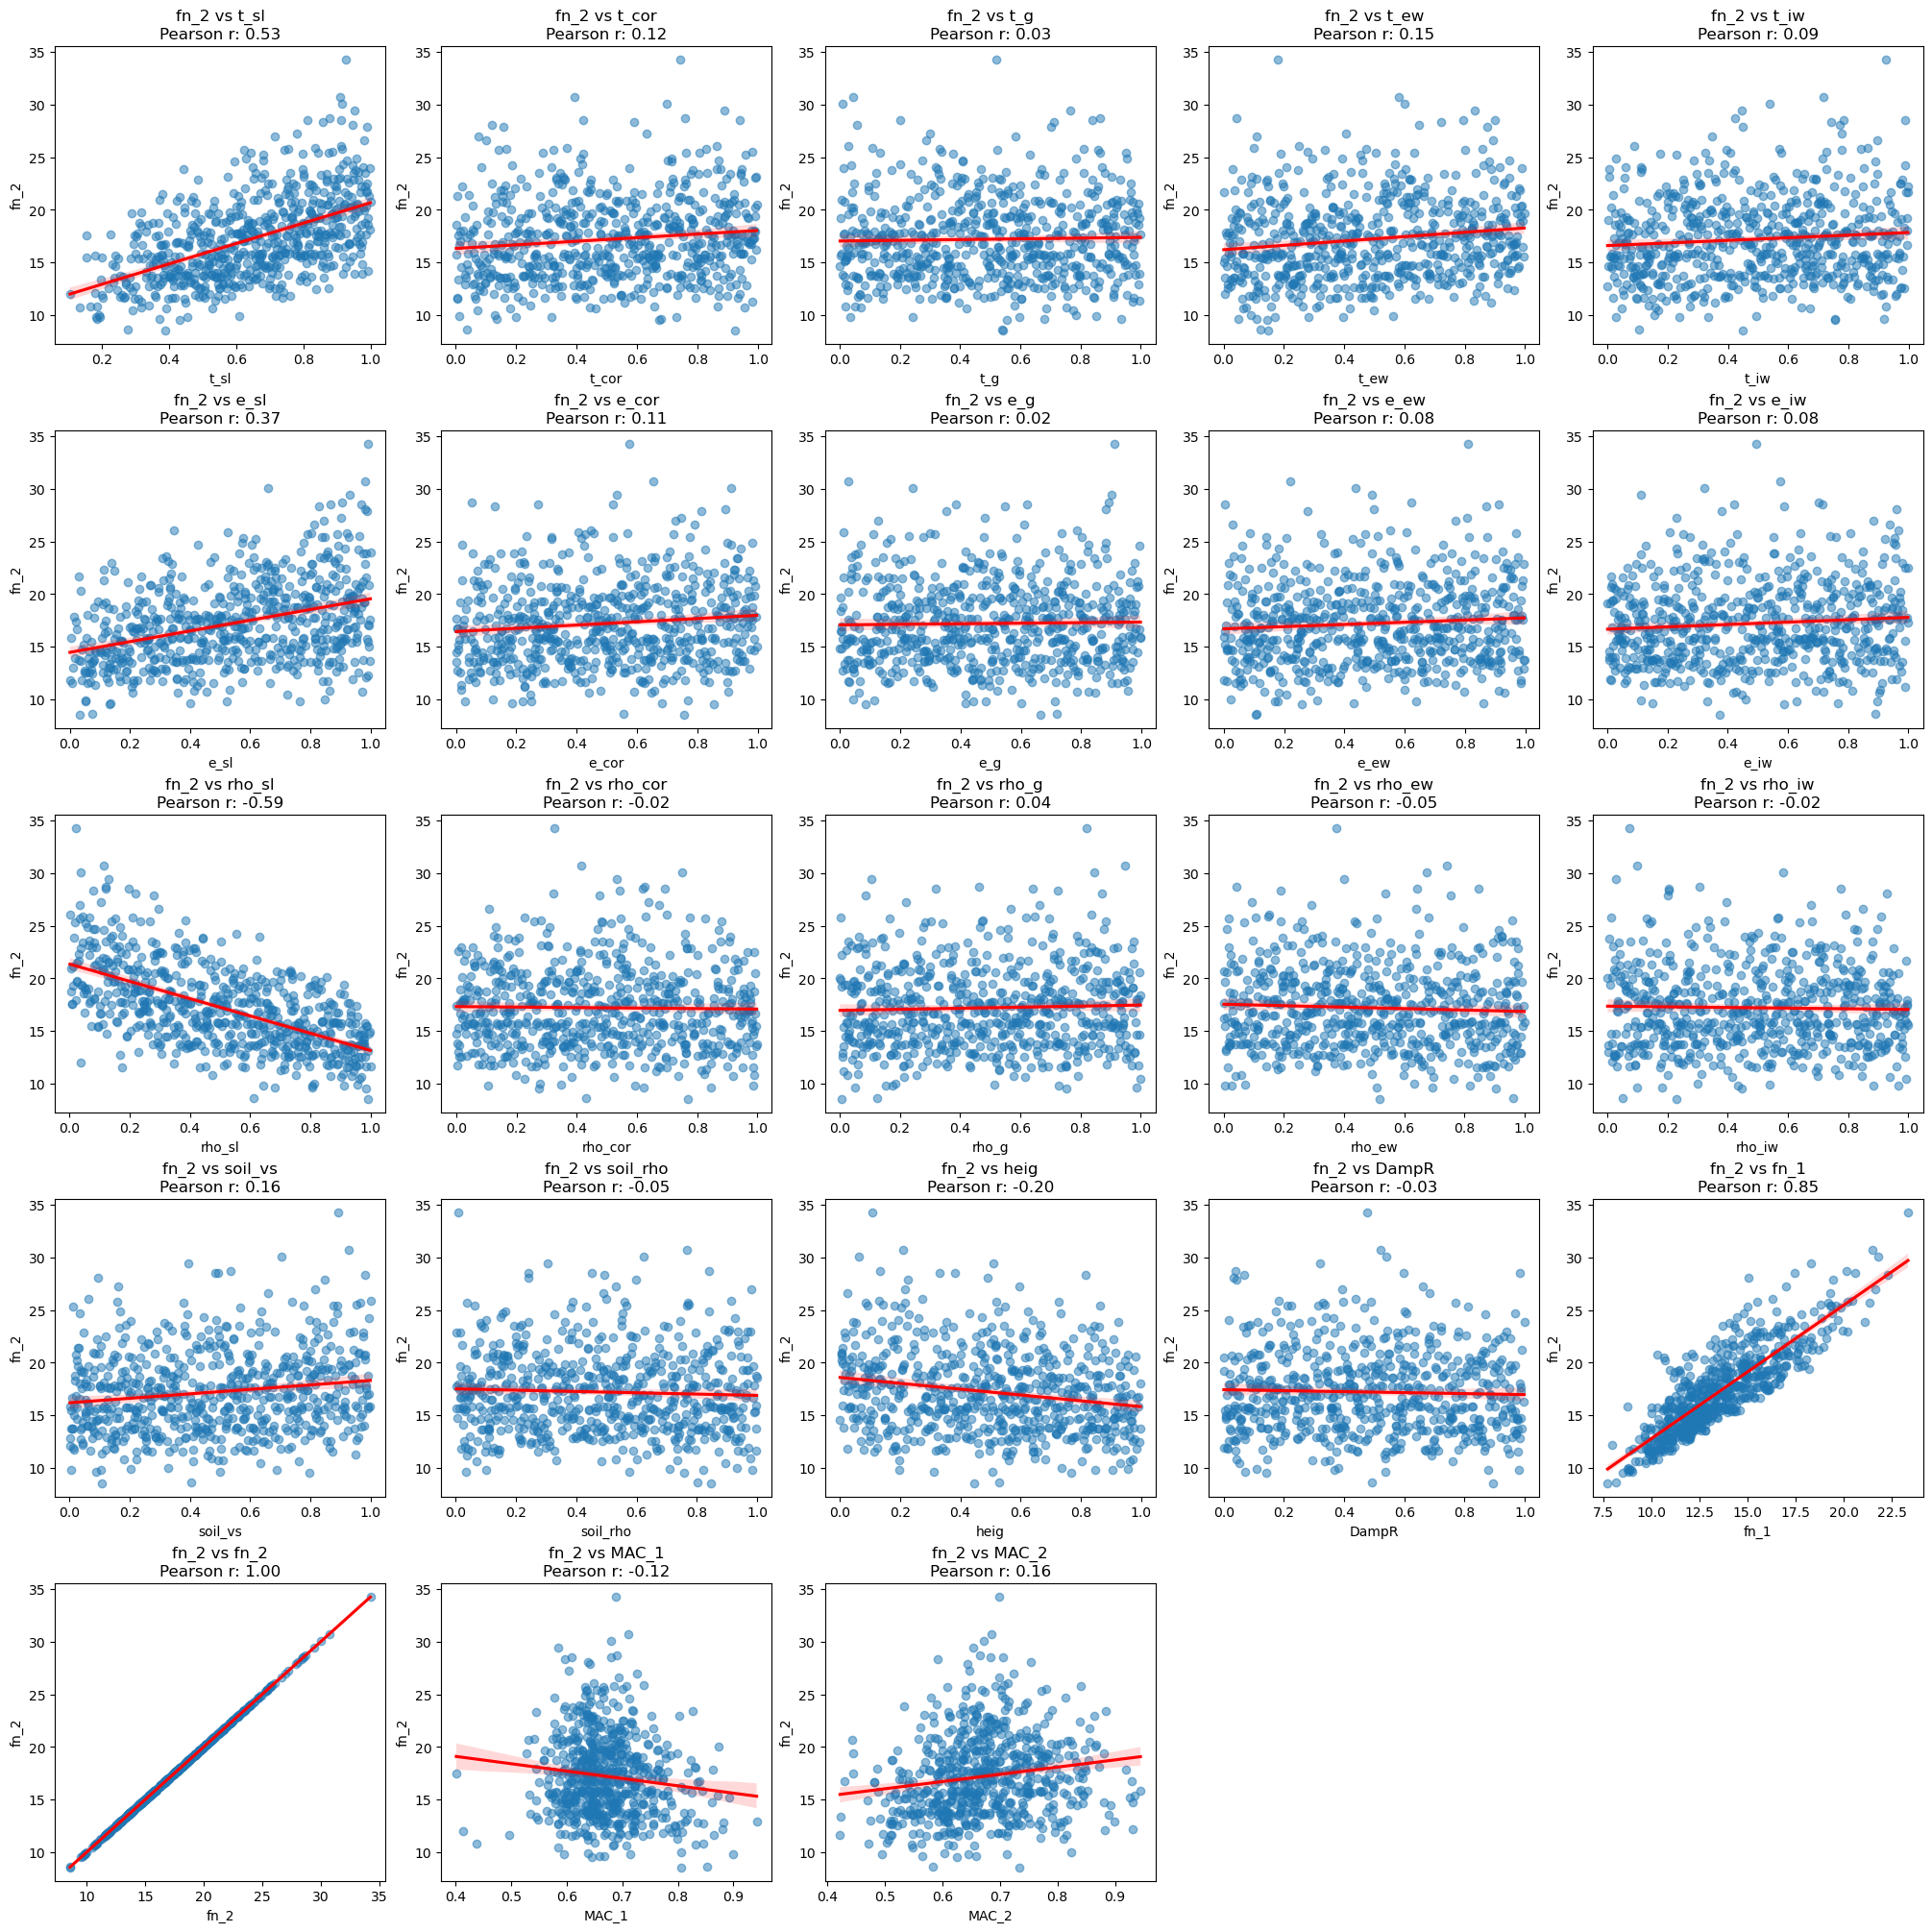

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

data_type = 'fn_2'
num_inputs = 24
num_cols = 5  # Number of plots per row
num_rows = (num_inputs + num_cols - 1) // num_cols  # Calculate rows dynamically

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows), constrained_layout=True)
axes = axes.flatten()

for i, input_col in enumerate(data.columns[:-1]):  # Exclude 'MAC'
    # Compute Pearson correlation
    result= linregress(data[input_col], data[data_type])
    corr = result.rvalue

    # Plot with regression line
    sns.regplot(
        x=input_col, y=data_type, data=data,
        ax=axes[i], line_kws={'color': 'red'}, scatter_kws={'alpha': 0.5}
    )
    axes[i].set_title(f"{data_type} vs {input_col}\nPearson r: {corr:.2f}")

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.show()


### Splitting the data for train and test

In [46]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy.stats import spearmanr

print(np.shape(valid_X))
print(np.shape(X))
inputs = valid_X
outputs = valid_Y2
outputs_fn1 = valid_Y2
outputs_fn2 = valid_Y3
outputs_fn3 = valid_Y4
outputs_fn4 = valid_Y5

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.1, random_state=3)
X_train_fn1, X_test_fn1, y_train_fn1, y_test_fn1 = train_test_split(inputs, outputs_fn1, test_size=0.1, random_state=3)
X_train_fn2, X_test_fn2, y_train_fn2, y_test_fn2 = train_test_split(inputs, outputs_fn2, test_size=0.1, random_state=3)
X_train_fn3, X_test_fn3, y_train_fn3, y_test_fn3 = train_test_split(inputs, outputs_fn3, test_size=0.1, random_state=3)
X_train_fn4, X_test_fn4, y_train_fn4, y_test_fn4 = train_test_split(inputs, outputs_fn4, test_size=0.1, random_state=3)

# Initialize PCA
pca = PCA(n_components=10)  # Choose the number of components (e.g., 10)

# Fit PCA on training inputs and transform both training and test sets
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by PCA components: {explained_variance}")

# Compute Pearson and Spearman correlations for each feature
correlations = []
for i in range(inputs.shape[1]):
    pearson_corr = np.corrcoef(X_train[:, i][:X_test.shape[0]], X_test[:, i])[0, 1]
    spearman_corr, _ = spearmanr(X_train[:, i][:X_test.shape[0]], X_test[:, i])
    correlations.append((f"Feature {i+1}", pearson_corr, spearman_corr))

# Display results in a DataFrame
df = pd.DataFrame(correlations, columns=["Feature", "Pearson Corr", "Spearman Corr"])
print(df)


(647, 19)
(1000, 19)
Explained variance by PCA components: [0.07177167 0.06989902 0.06578696 0.0646851  0.06129847 0.05874925
 0.05770011 0.05583626 0.0544992  0.05300103]
       Feature  Pearson Corr  Spearman Corr
0    Feature 1     -0.278201      -0.251442
1    Feature 2     -0.114576      -0.097902
2    Feature 3     -0.010117      -0.016783
3    Feature 4      0.182249       0.169056
4    Feature 5     -0.036319      -0.038068
5    Feature 6     -0.056497      -0.063287
6    Feature 7     -0.010257      -0.030201
7    Feature 8      0.086479       0.067832
8    Feature 9      0.140362       0.104502
9   Feature 10     -0.115827      -0.163374
10  Feature 11      0.171125       0.172465
11  Feature 12      0.176336       0.190691
12  Feature 13     -0.140311      -0.157605
13  Feature 14      0.006980      -0.013024
14  Feature 15      0.066084       0.035883
15  Feature 16      0.172510       0.170061
16  Feature 17      0.195773       0.192220
17  Feature 18     -0.012084       0

### Building the surrogate model using GPR

R² Score: 0.9810652995599193
NMSE: 0.018934700440080773


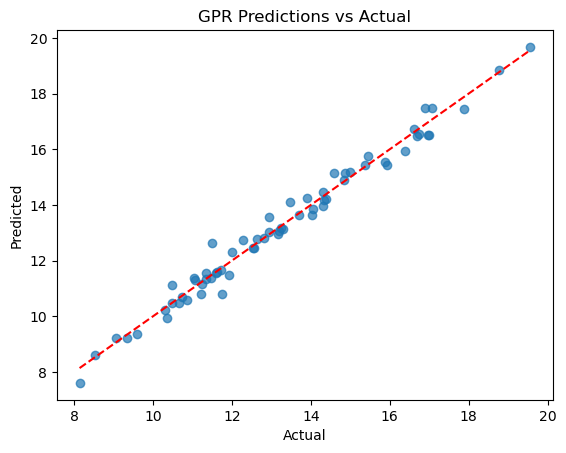

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
# Define the kernel (adjust as needed)
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# Initialize and train the GPR model
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr.fit(X_train, y_train)

# Predict on the test set
y_pred = gpr.predict(X_test)

# Compute R² score
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")

# Compute NMSE (Normalized Mean Squared Error)
nmse = mean_squared_error(y_test, y_pred) / np.var(y_test)
print(f"NMSE: {nmse}")


plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("GPR Predictions vs Actual")
plt.show()


### Visualization of the surrogate model

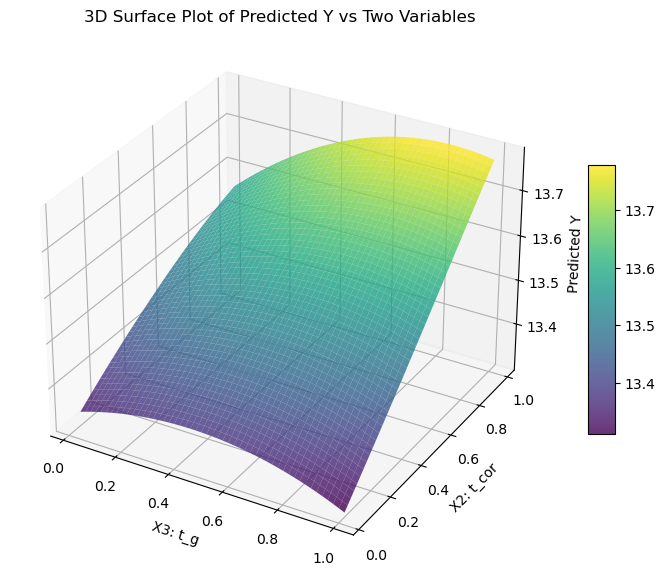

In [48]:

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the indices of the two variables you want to vary
var1_index = 2  # Index for the 5th variable (Python is zero-indexed)
var2_index = 1  # Index for the 10th variable

input_name = ['t_sl' ,'t_cor', 't_g', 't_ew', 't_iw',
              'e_sl' ,'e_cor', 'e_g', 'e_ew', 'e_iw',
              'rho_sl' ,'rho_cor', 'rho_g', 'rho_ew', 'rho_iw',
              'soil_vs' ,'soil_rho', 'heig', 'DampR']

# Select the desired variables from X_test
var1 = X_test[:, var1_index]
var2 = X_test[:, var2_index]

# Calculate the mean of the remaining 17 variables
mean_vars = np.mean(X_test, axis=0)


# Generate a grid of values for var1 and var2 (these will vary, others are fixed)
var1_grid, var2_grid = np.meshgrid(np.linspace(var1.min(), var1.max(), 50),
                                   np.linspace(var2.min(), var2.max(), 50))

# Flatten the grids for var1 and var2 to create 1D arrays
var1_flat = var1_grid.ravel()
var2_flat = var2_grid.ravel()

# Create a new input matrix for predictions
# Stack the selected variables and tile the other variables' mean values
X_grid = np.column_stack([  np.tile(mean_vars, (len(var1_flat), 1))])
X_grid[:,var1_index] = var1_flat
X_grid[:,var2_index] = var2_flat
# Generate predictions for the grid (assuming gpr is your trained model)
y_pred_grid = gpr.predict(X_grid).reshape(var1_grid.shape)

# Now, y_pred_grid has shape (50, 50), matching the grid's shape

# Create a 3D figure
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Surface plot

surf = ax.plot_surface(var1_grid, var2_grid, y_pred_grid, cmap='viridis', alpha=0.8)
#ax.scatter(var1, var2, y_test, c='red', label='Test Results', s=50)

# Add labels and title
ax.set_xlabel(f'X{var1_index + 1}: {input_name[var1_index]}')
ax.set_ylabel(f'X{var2_index + 1}: {input_name[var2_index]}')
ax.set_zlabel('Predicted Y')

ax.set_title('3D Surface Plot of Predicted Y vs Two Variables')
# Add color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

# Show the plot
plt.show()




### Build the surrogate model for two natural frequencies

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
# Define the kernel (adjust as needed)
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# Initialize and train the GPR model
gpr_fn1 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn1.fit(X_train_fn1, y_train_fn1)
# Predict on the test set
y_pred_fn1 = gpr_fn1.predict(X_test_fn1)


# Initialize and train the GPR model
gpr_fn2 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn2.fit(X_train_fn2, y_train_fn2)
# Predict on the test set
y_pred_fn2 = gpr_fn2.predict(X_test_fn2)


# Initialize and train the GPR model
gpr_fn3 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn3.fit(X_train_fn3, y_train_fn3)
# Predict on the test set
y_pred_fn3 = gpr_fn3.predict(X_test_fn3)


# Initialize and train the GPR model
gpr_fn4 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn4.fit(X_train_fn4, y_train_fn4)
# Predict on the test set
y_pred_fn4 = gpr_fn4.predict(X_test_fn4)

print(f"gpr_fn1 performace: R² Score: {r2_score(y_test_fn1, y_pred_fn1)}, NMSE: {mean_squared_error(y_test_fn1, y_pred_fn1) / np.var(y_test_fn1)}")
print(f"gpr_fn1 performace: R² Score: {r2_score(y_test_fn2, y_pred_fn2)}, NMSE: {mean_squared_error(y_test_fn2, y_pred_fn2) / np.var(y_test_fn2)}")
print(f"gpr_MAC1 performace: R² Score: {r2_score(y_test_fn3, y_pred_fn3)}, NMSE: {mean_squared_error(y_test_fn3, y_pred_fn3) / np.var(y_test_fn3)}")
print(f"gpr_MAC2 performace: R² Score: {r2_score(y_test_fn4, y_pred_fn4)}, NMSE: {mean_squared_error(y_test_fn4, y_pred_fn4) / np.var(y_test_fn4)}")


gpr_fn1 performace: R² Score: 0.9807621855614794, NMSE: 0.019237814438520608
gpr_fn1 performace: R² Score: 0.9701661531966949, NMSE: 0.029833846803305156
gpr_MAC1 performace: R² Score: -0.3839699935894654, NMSE: 1.3839699935894654
gpr_MAC2 performace: R² Score: -0.4091611493907772, NMSE: 1.4091611493907772
